# Forecasting - Exercise

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Dataset: Alcohol sales

https://fred.stlouisfed.org/series/S4248SM144NCEN
Merchant Wholesalers, Except Manufacturers' Sales Branches and Offices: Nondurable Goods: Beer, Wine, and Distilled Alcoholic Beverages Sales

## Load data

In [2]:
Y = pd.read_csv("./data/Alcohol_Sales2024.csv")
Y.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459.0
1,1992-02-01,3458.0
2,1992-03-01,4002.0
3,1992-04-01,4564.0
4,1992-05-01,4221.0


In [3]:
Y.set_index('DATE', inplace=True)
Y.index = pd.PeriodIndex(Y.index, freq='M')
y = Y['S4248SM144NCEN']
y.head()

DATE
1992-01    3459.0
1992-02    3458.0
1992-03    4002.0
1992-04    4564.0
1992-05    4221.0
Freq: M, Name: S4248SM144NCEN, dtype: float64

<Axes: xlabel='DATE'>

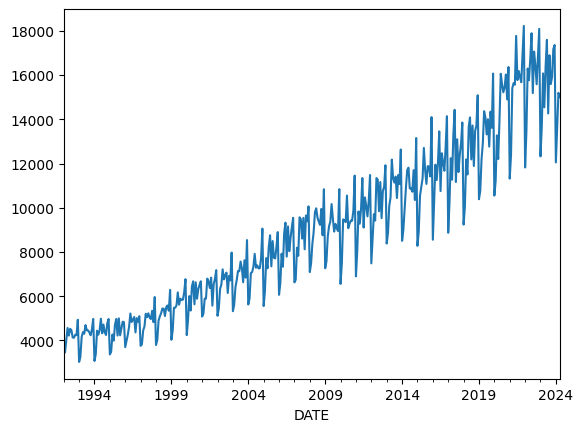

In [4]:
y.plot()

## Split data

In [5]:
from sktime.split import temporal_train_test_split

In [6]:
y_train, y_test = temporal_train_test_split(y)
y_train.shape, y_test.shape

((291,), (97,))

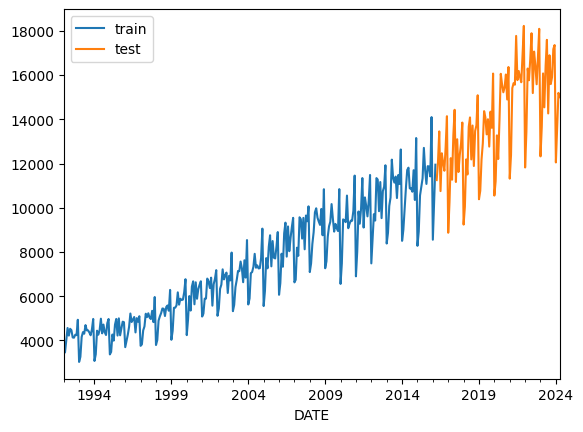

In [7]:
y_train.plot(label='train')
y_test.plot(label='test')
plt.legend()
plt.show()

---

## Exercise
Find the best possible forecasting model for the alcohol sales dataset in terms of MAE (mean absolute error).
Remember not to use the test set for model selection.

---

In [8]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [9]:
mae = MeanAbsoluteError()
fh = np.arange(1, len(y_test) + 1)
cv = ExpandingWindowSplitter(fh, initial_window=96, step_length=12)

In [10]:
# how many splits?
splitted = list(cv.split(y_train))
len(splitted)

9

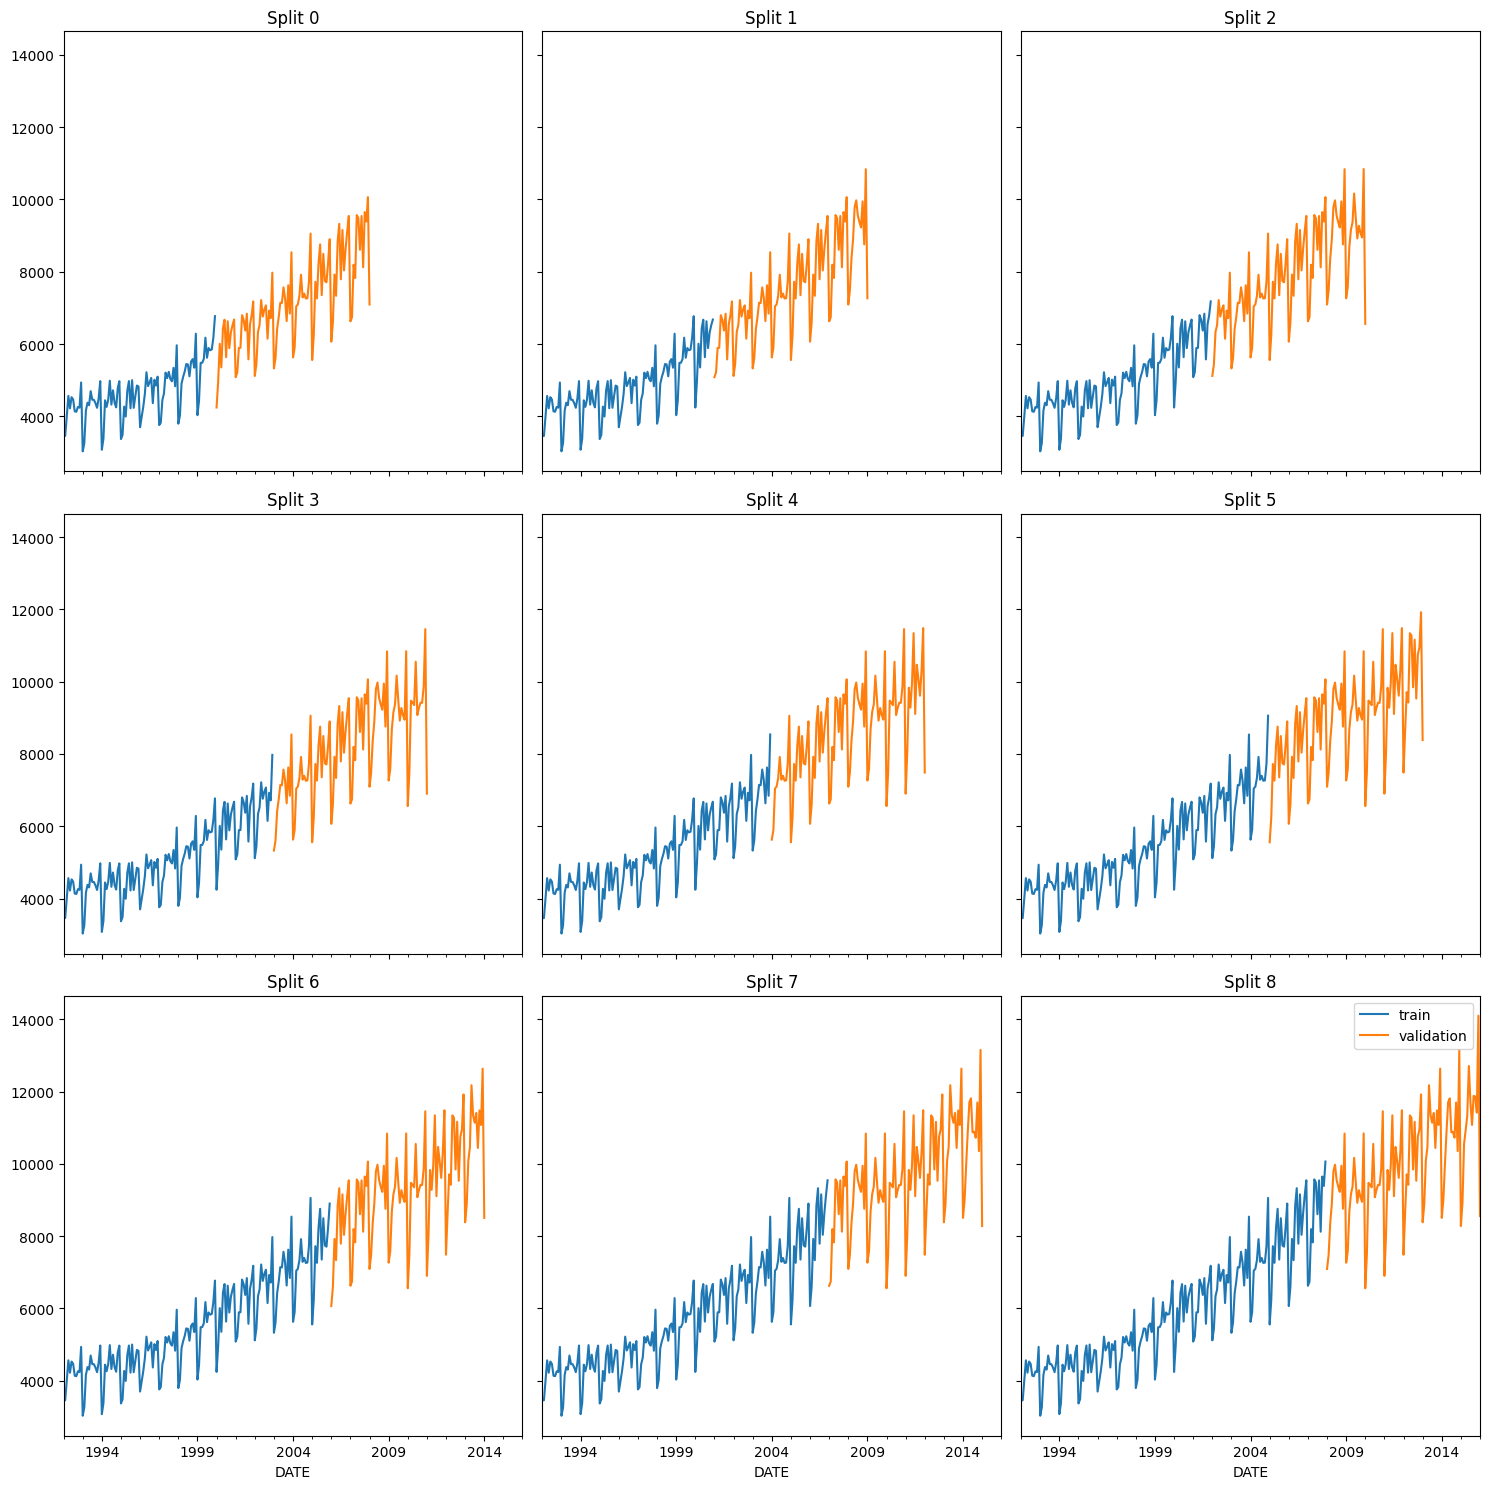

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
for i, (train, test) in enumerate(splitted):
    axs[i // 3, i % 3].set_title(f"Split {i}")
    y.iloc[train].plot(ax=axs[i // 3, i % 3], label='train')
    y.iloc[test].plot(ax=axs[i // 3, i % 3], label='validation')
plt.tight_layout()
plt.legend()
plt.show()

## Naive forecasting

In [12]:
from sktime.forecasting.naive import NaiveForecaster

### Mean

#### Cross-validation

In [13]:
scores_df = evaluate(NaiveForecaster(strategy="mean"), cv=cv, y=y_train, scoring=MeanAbsoluteError())
scores_df["test_MeanAbsoluteError"].mean()

np.float64(3341.7683294975463)

#### Performance on the test set

In [14]:
forecaster = NaiveForecaster(strategy="mean")

In [15]:
forecaster.fit(y_train)

NaiveForecaster(strategy='mean')

In [16]:
y_pred = forecaster.predict(fh)

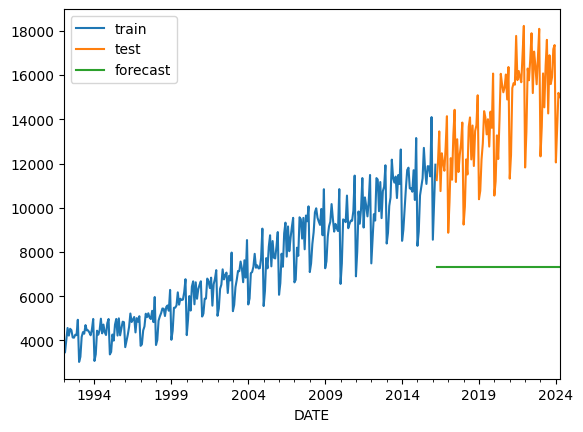

In [17]:
y_train.plot(label='train')
y_test.plot(label='test')
y_pred.plot(label='forecast')
plt.legend()
plt.show()

In [18]:
mae(y_pred, y_test)

np.float64(6675.18213058419)

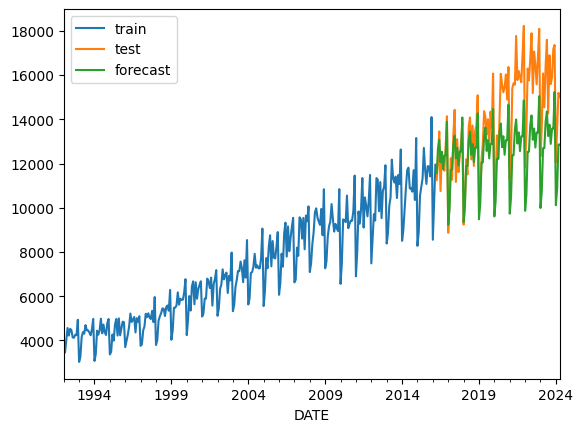

np.float64(1620.1258173818878)

In [ ]:
from sktime.forecasting.theta import ThetaForecaster

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
y_train.plot(label='train')
y_test.plot(label='test')
y_pred.plot(label='forecast')
plt.legend()
plt.show()

In [23]:
print("MAE: ", mae(y_pred, y_test))

MAE:  1134.1423181944579


13:11:07 - cmdstanpy - INFO - Chain [1] start processing


13:11:07 - cmdstanpy - INFO - Chain [1] done processing


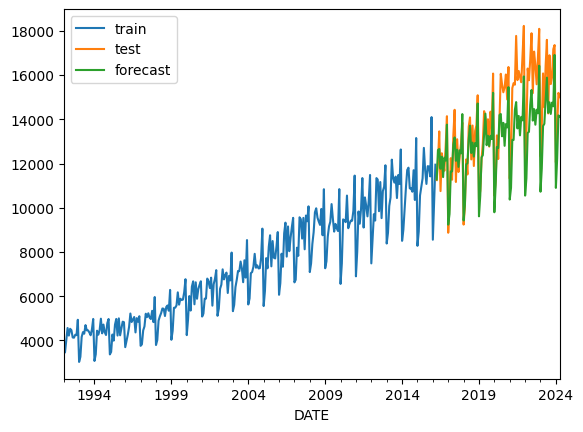

In [24]:
from sktime.forecasting.fbprophet import Prophet
forecaster = Prophet(  
    seasonality_mode='multiplicative',
    n_changepoints=int(len(y_train) / 12),
    yearly_seasonality=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
y_train.plot(label='train')
y_test.plot(label='test')
y_pred.plot(label='forecast')
plt.legend()

In [25]:
print("MAE: ", mae(y_pred, y_test))

MAE:  1134.1423181944579


In [26]:
from sktime.forecasting.compose import make_reduction

In [28]:
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.compose import OptionalPassthrough
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.transformations.series.boxcox import LogTransformer
from sklearn.tree import DecisionTreeRegressor

In [ ]:
pipe = TransformedTargetForecaster(steps=[
    ("log", OptionalPassthrough(LogTransformer())),
    Differencer(),
    ("dt", make_reduction(
    DecisionTreeRegressor(random_state=1),
))
]
)

param_grid = {
    "log__passthrough": [True, False],
    "dt__window_length": [6, 12, 24, 48, 96]
}
gscv = ForecastingGridSearchCV(
    pipe, cv=cv, param_grid=param_grid, scoring=MeanAbsoluteError()
)

/home/giuseppe/pmts/pmts_env/lib/python3.12/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster TransformedTargetForecaster failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff NaT, and len(y_train)=96.
                The score will be set to nan.
                Failed forecaster with parameters: TransformedTargetForecaster(steps=[('log',
                                    OptionalPassthrough(passthrough=True,
                                                        transformer=LogTransformer())),
                                   Differencer(),
                                   ('dt',
                                    RecursiveTabularRegressionForecaster(estimator=DecisionTreeRegressor(random_state=1),
                                                      

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
                                                   initial_window=96,
                                                   step_length=12),
                        forecaster=TransformedTargetForecaster(steps=[('log',
                                                                       OptionalPassthrough(transformer=LogTransformer())),
                                                                      Differencer(),
                                                                      ('dt',
                                                                       RecursiveTabularRegressionForecaster(estimator=DecisionTreeRegressor(random_state=1)))]),
                        param_grid={'dt__window_length': [6, 12, 24, 48, 96],
                                    'log__passthrough': [True, False]},
                        scoring=MeanAbsoluteError())

In [ ]:
gscv.fit(y_train)

In [32]:
gscv.best_params_

{'dt__window_length': 24, 'log__passthrough': False}

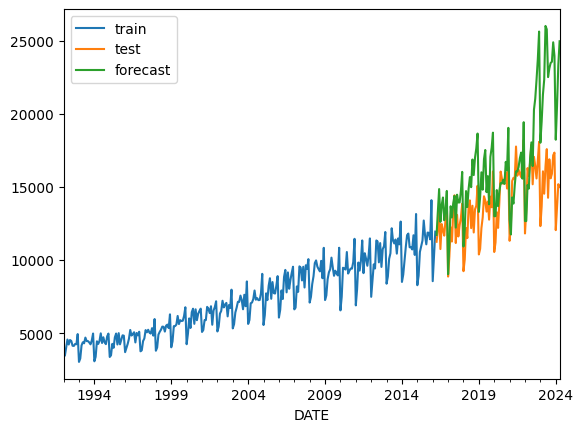

In [33]:
y_pred = gscv.predict(fh)
y_train.plot(label='train')
y_test.plot(label='test')
y_pred.plot(label='forecast')
plt.legend()
plt.show()

In [34]:
print("MAE: ", mae(y_pred, y_test))

MAE:  2778.3619380821006


In [39]:
from sktime.regression.kernel_based import RocketRegressor
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.boxcox import LogTransformer

In [40]:
pipe = LogTransformer() * Detrender() * Deseasonalizer() * Differencer() * make_reduction(
    RocketRegressor(random_state=1, rocket_transform="minirocket"),
    window_length=12
)
pipe

TransformedTargetForecaster(steps=[LogTransformer(), Detrender(),
                                   Deseasonalizer(), Differencer(),
                                   RecursiveTimeSeriesRegressionForecaster(estimator=RocketRegressor(random_state=1,
                                                                                                     rocket_transform='minirocket'),
                                                                           window_length=12)])

In [41]:
pipe.fit(y_train)

TransformedTargetForecaster(steps=[LogTransformer(), Detrender(),
                                   Deseasonalizer(), Differencer(),
                                   RecursiveTimeSeriesRegressionForecaster(estimator=RocketRegressor(random_state=1,
                                                                                                     rocket_transform='minirocket'),
                                                                           window_length=12)])

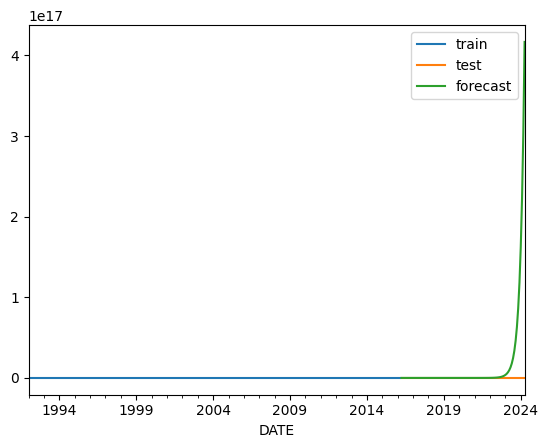

In [43]:
y_pred = pipe.predict(fh)
y_train.plot(label='train')
y_test.plot(label='test')
y_pred.plot(label='forecast')
plt.legend()
plt.show()